In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
import os

In [ ]:
OUTPUT_PATH = '/content/drive/MyDrive/processed_data'
preprocessing_info = np.load(os.path.join(OUTPUT_PATH, 'preprocessing_info.npy'),
                             allow_pickle=True).item()

IMG_SIZE = preprocessing_info['img_size']
NUM_CLASSES = preprocessing_info['num_classes']
CLASS_NAMES = preprocessing_info['class_names']
CLASS_WEIGHTS = preprocessing_info['class_weights']


print(f"Image Size: {IMG_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")


Image Size: (224, 224)
Number of Classes: 5
Classes: ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']


In [ ]:
# =============================================
# 2. BUILD VGG-19 ARCHITECTURE FROM SCRATCH
# =============================================
def build_vgg19_from_scratch(input_shape=(224, 224, 3), num_classes=5):
    """
    Build VGG-19 architecture from scratch

    Architecture Details:
    - 16 Convolutional Layers (with ReLU activation)
    - 5 Max Pooling Layers
    - 3 Fully Connected Layers
    - Total: 19 weight layers (16 conv + 3 fc)

    Structure:
    - Block 1: 2x Conv (64 filters)  + MaxPool
    - Block 2: 2x Conv (128 filters) + MaxPool
    - Block 3: 4x Conv (256 filters) + MaxPool
    - Block 4: 4x Conv (512 filters) + MaxPool
    - Block 5: 4x Conv (512 filters) + MaxPool
    - FC: 4096 -> 4096 -> num_classes
    """

    model = models.Sequential(name='VGG19_from_scratch')

    # ============= BLOCK 1 =============
    # 2 Conv layers with 64 filters
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            input_shape=input_shape, name='block1_conv1'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block1_conv2'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    # ============= BLOCK 2 =============
    # 2 Conv layers with 128 filters
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block2_conv1'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block2_conv2'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # ============= BLOCK 3 =============
    # 4 Conv layers with 256 filters
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block3_conv1'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block3_conv2'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block3_conv3'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block3_conv4'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # ============= BLOCK 4 =============
    # 4 Conv layers with 512 filters
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block4_conv1'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block4_conv2'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block4_conv3'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block4_conv4'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    # ============= BLOCK 5 =============
    # 4 Conv layers with 512 filters
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block5_conv1'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block5_conv2'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block5_conv3'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                            kernel_initializer='he_normal',
                            kernel_regularizer=l2(0.0005),
                            name='block5_conv4'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

    # ============= FULLY CONNECTED LAYERS =============
    model.add(layers.Flatten(name='flatten'))

    # FC Layer 1: 4096 units
    model.add(layers.Dense(4096, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(0.0005),
                          name='fc1'))
    model.add(layers.Dropout(0.5, name='dropout1'))

    # FC Layer 2: 4096 units
    model.add(layers.Dense(4096, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(0.0005),
                          name='fc2'))
    model.add(layers.Dropout(0.5, name='dropout2'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax',
                          kernel_initializer='glorot_uniform',
                          name='predictions'))

    return model

# Build the model
print("\nBuilding VGG-19 architecture from scratch...")
vgg19_model = build_vgg19_from_scratch(input_shape=(*IMG_SIZE, 3), num_classes=NUM_CLASSES)

# Display model summary
print("\n" + "="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)
vgg19_model.summary()

# Count parameters
total_params = vgg19_model.count_params()
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {total_params:,}")


Building VGG-19 architecture from scratch...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MODEL ARCHITECTURE SUMMARY


Model: "VGG19_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 139,590,725 (532.50 MB)

 Trainable params: 139,590,725 (532.50 MB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 139,590,725
Trainable Parameters: 139,590,725


COMPILE MODEL

In [ ]:
# Using SGD with momentum (as in original paper)
optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

vgg19_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

SETUP CALLBACKS

In [ ]:
# Create directory for saving models
model_save_path = '/content/drive/MyDrive/models/vgg19_scratch'
os.makedirs(model_save_path, exist_ok=True)

# Callbacks
callbacks_list = [
    # Save best model based on validation accuracy
    callbacks.ModelCheckpoint(
        filepath=os.path.join(model_save_path, 'vgg19_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # CSV logger
    callbacks.CSVLogger(
        os.path.join(model_save_path, 'training_log.csv'),
        append=False
    )
]

TRAIN MODEL

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

DATASET_PATH = '/content/drive/MyDrive/weather_dataset/dataset'
BATCH_SIZE = 32

In [ ]:
# Load split data
X_train = np.load(os.path.join(OUTPUT_PATH, 'X_train.npy'), allow_pickle=True)
X_val = np.load(os.path.join(OUTPUT_PATH, 'X_val.npy'), allow_pickle=True)
X_test = np.load(os.path.join(OUTPUT_PATH, 'X_test.npy'), allow_pickle=True)
y_train = np.load(os.path.join(OUTPUT_PATH, 'y_train.npy'), allow_pickle=True)
y_val = np.load(os.path.join(OUTPUT_PATH, 'y_val.npy'), allow_pickle=True)
y_test = np.load(os.path.join(OUTPUT_PATH, 'y_test.npy'), allow_pickle=True)

In [ ]:
# Create generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def create_generator(datagen, X, y, batch_size, shuffle=True):
    df = pd.DataFrame({'filename': X, 'class': y.astype(str)})
    return datagen.flow_from_dataframe(
        dataframe=df, x_col='filename', y_col='class',
        target_size=IMG_SIZE, batch_size=batch_size,
        class_mode='sparse', shuffle=shuffle, seed=42
    )

train_generator = create_generator(train_datagen, X_train, y_train, BATCH_SIZE, True)
val_generator = create_generator(val_datagen, X_val, y_val, BATCH_SIZE, False)
test_generator = create_generator(val_datagen, X_test, y_test, BATCH_SIZE, False)


Found 1050 validated image filenames belonging to 5 classes.
Found 300 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


In [ ]:
EPOCHS = 50

start_time = time.time()

history = vgg19_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2366 - loss: 15.5321 
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 517s 14s/step - accuracy: 0.2385 - loss: 15.5251 - val_accuracy: 0.4000 - val_loss: 14.8775 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.3955 - loss: 15.0313
Epoch 2: val_accuracy improved from 0.40000 to 0.58667, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3967 - loss: 15.0291 - val_accuracy: 0.5867 - val_loss: 14.6753 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5336 - loss: 14.8308
Epoch 3: val_accuracy did not improve from 0.58667
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5338 - loss: 14.8299 - val_accuracy: 0.5033 - val_loss: 14.9048 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.5805 - loss: 14.6956
Epoch 4: val_accuracy improved from 0.58667 to 0.70333, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5805 - loss: 14.6950 - val_accuracy: 0.7033 - val_loss: 14.4555 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6437 - loss: 14.5947
Epoch 5: val_accuracy improved from 0.70333 to 0.72000, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6433 - loss: 14.5951 - val_accuracy: 0.7200 - val_loss: 14.4150 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6234 - loss: 14.5788
Epoch 6: val_accuracy did not improve from 0.72000
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6237 - loss: 14.5787 - val_accuracy: 0.7067 - val_loss: 14.4430 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6328 - loss: 14.5821
Epoch 7: val_accuracy did not improve from 0.72000
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6334 - loss: 14.5805 - val_accuracy: 0.6233 - val_loss: 14.4376 - learning_rate: 0.0010
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.6468 - loss: 14.5132
Epoch 8: val_accuracy did not improve from 0.72000
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 956ms/step - accuracy: 0.6473 - loss: 14.5122 - val_accuracy: 0.6267 - val_loss: 14.4466 - learning_rate: 0.0010
Epoch 9/50
33/33 ━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6833 - loss: 14.4388 - val_accuracy: 0.7433 - val_loss: 14.3050 - learning_rate: 0.0010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6840 - loss: 14.4230
Epoch 10: val_accuracy did not improve from 0.74333
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6831 - loss: 14.4244 - val_accuracy: 0.6800 - val_loss: 14.4297 - learning_rate: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.6316 - loss: 14.4843
Epoch 11: val_accuracy did not improve from 0.74333
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 954ms/step - accuracy: 0.6319 - loss: 14.4842 - val_accuracy: 0.7233 - val_loss: 14.3406 - learning_rate: 0.0010
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.6646 - loss: 14.4157
Epoch 12: val_accuracy did not improve from 0.74333
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 983ms/step - accuracy: 0.6643 - loss: 14.4163 - val_accuracy: 0.7333 - val_loss: 14.2919 - learning_rate: 0.0010
Epoch 13/50
3

33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6828 - loss: 14.3984 - val_accuracy: 0.7567 - val_loss: 14.2017 - learning_rate: 0.0010
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7040 - loss: 14.3050
Epoch 16: val_accuracy did not improve from 0.75667
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7041 - loss: 14.3054 - val_accuracy: 0.7500 - val_loss: 14.1973 - learning_rate: 0.0010
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7061 - loss: 14.2992
Epoch 17: val_accuracy did not improve from 0.75667
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 957ms/step - accuracy: 0.7056 - loss: 14.2997 - val_accuracy: 0.7200 - val_loss: 14.2456 - learning_rate: 0.0010
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.6873 - loss: 14.3026
Epoch 18: val_accuracy improved from 0.75667 to 0.77000, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6865 - loss: 14.3038 - val_accuracy: 0.7700 - val_loss: 14.2017 - learning_rate: 0.0010
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7082 - loss: 14.2807
Epoch 19: val_accuracy improved from 0.77000 to 0.78667, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7086 - loss: 14.2802 - val_accuracy: 0.7867 - val_loss: 14.1088 - learning_rate: 0.0010
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7140 - loss: 14.2715
Epoch 20: val_accuracy did not improve from 0.78667
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7137 - loss: 14.2718 - val_accuracy: 0.7867 - val_loss: 14.1292 - learning_rate: 0.0010
Epoch 21/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7410 - loss: 14.2065
Epoch 21: val_accuracy did not improve from 0.78667
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7409 - loss: 14.2070 - val_accuracy: 0.6533 - val_loss: 14.2827 - learning_rate: 0.0010
Epoch 22/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.7118 - loss: 14.2672
Epoch 22: val_accuracy did not improve from 0.78667
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 961ms/step - accuracy: 0.7119 - loss: 14.2680 - val_accuracy: 0.6867 - val_loss: 14.3152 - learning_rate: 0.0010
Epoch 23/50
33/33 ━

33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7228 - loss: 14.1918 - val_accuracy: 0.8000 - val_loss: 14.0368 - learning_rate: 5.0000e-04
Epoch 26/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7777 - loss: 14.0637
Epoch 26: val_accuracy did not improve from 0.80000
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7774 - loss: 14.0646 - val_accuracy: 0.7867 - val_loss: 14.0252 - learning_rate: 5.0000e-04
Epoch 27/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.7845 - loss: 14.0471
Epoch 27: val_accuracy improved from 0.80000 to 0.82000, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7843 - loss: 14.0480 - val_accuracy: 0.8200 - val_loss: 13.9704 - learning_rate: 5.0000e-04
Epoch 28/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8169 - loss: 13.9886
Epoch 28: val_accuracy did not improve from 0.82000
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8164 - loss: 13.9896 - val_accuracy: 0.7833 - val_loss: 13.9995 - learning_rate: 5.0000e-04
Epoch 29/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.7730 - loss: 14.0510
Epoch 29: val_accuracy did not improve from 0.82000
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 981ms/step - accuracy: 0.7734 - loss: 14.0501 - val_accuracy: 0.8200 - val_loss: 13.9617 - learning_rate: 5.0000e-04
Epoch 30/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.7978 - loss: 14.0033
Epoch 30: val_accuracy improved from 0.82000 to 0.82667, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7977 - loss: 14.0038 - val_accuracy: 0.8267 - val_loss: 13.9420 - learning_rate: 5.0000e-04
Epoch 31/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7861 - loss: 14.0409
Epoch 31: val_accuracy improved from 0.82667 to 0.83000, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7864 - loss: 14.0399 - val_accuracy: 0.8300 - val_loss: 13.9127 - learning_rate: 5.0000e-04
Epoch 32/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8121 - loss: 13.9338
Epoch 32: val_accuracy did not improve from 0.83000
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8118 - loss: 13.9350 - val_accuracy: 0.8000 - val_loss: 13.9671 - learning_rate: 5.0000e-04
Epoch 33/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7941 - loss: 14.0110
Epoch 33: val_accuracy improved from 0.83000 to 0.83667, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7944 - loss: 14.0100 - val_accuracy: 0.8367 - val_loss: 13.9331 - learning_rate: 5.0000e-04
Epoch 34/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8347 - loss: 13.9510
Epoch 34: val_accuracy did not improve from 0.83667
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8348 - loss: 13.9504 - val_accuracy: 0.7567 - val_loss: 14.1899 - learning_rate: 5.0000e-04
Epoch 35/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.7579 - loss: 14.0777
Epoch 35: val_accuracy did not improve from 0.83667
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 944ms/step - accuracy: 0.7590 - loss: 14.0748 - val_accuracy: 0.7833 - val_loss: 14.0151 - learning_rate: 5.0000e-04
Epoch 36/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.8375 - loss: 13.9078
Epoch 36: val_accuracy did not improve from 0.83667
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 955ms/step - accuracy: 0.8374 - loss: 13.9078 - val_accuracy: 0.8333 - val_loss: 13.8928 - learning_rate: 5.000

33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8214 - loss: 13.9351 - val_accuracy: 0.8567 - val_loss: 13.8419 - learning_rate: 5.0000e-04
Epoch 39/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8481 - loss: 13.8180
Epoch 39: val_accuracy improved from 0.85667 to 0.86667, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8482 - loss: 13.8183 - val_accuracy: 0.8667 - val_loss: 13.7986 - learning_rate: 5.0000e-04
Epoch 40/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8599 - loss: 13.8322
Epoch 40: val_accuracy did not improve from 0.86667
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8593 - loss: 13.8335 - val_accuracy: 0.8400 - val_loss: 13.8357 - learning_rate: 5.0000e-04
Epoch 41/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8492 - loss: 13.8666
Epoch 41: val_accuracy did not improve from 0.86667
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8492 - loss: 13.8658 - val_accuracy: 0.8533 - val_loss: 13.8191 - learning_rate: 5.0000e-04
Epoch 42/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.8522 - loss: 13.8567
Epoch 42: val_accuracy did not improve from 0.86667
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 944ms/step - accuracy: 0.8521 - loss: 13.8566 - val_accuracy: 0.8367 - val_loss: 13.8203 - learning_rate: 5.0000e-04
Epo

33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8340 - loss: 13.8306 - val_accuracy: 0.8700 - val_loss: 13.7780 - learning_rate: 5.0000e-04
Epoch 44/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8505 - loss: 13.8355
Epoch 44: val_accuracy did not improve from 0.87000
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8511 - loss: 13.8340 - val_accuracy: 0.7867 - val_loss: 13.9601 - learning_rate: 5.0000e-04
Epoch 45/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.8549 - loss: 13.7867
Epoch 45: val_accuracy did not improve from 0.87000
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8549 - loss: 13.7871 - val_accuracy: 0.8667 - val_loss: 13.7764 - learning_rate: 5.0000e-04
Epoch 46/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8376 - loss: 13.8246
Epoch 46: val_accuracy improved from 0.87000 to 0.87333, saving model to /content/drive/MyDrive/models/vgg19_scratch/vgg19_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8381 - loss: 13.8231 - val_accuracy: 0.8733 - val_loss: 13.7727 - learning_rate: 5.0000e-04
Epoch 47/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8529 - loss: 13.8066
Epoch 47: val_accuracy did not improve from 0.87333
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8530 - loss: 13.8059 - val_accuracy: 0.8400 - val_loss: 13.7820 - learning_rate: 5.0000e-04
Epoch 48/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8614 - loss: 13.7488
Epoch 48: val_accuracy did not improve from 0.87333
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 986ms/step - accuracy: 0.8615 - loss: 13.7486 - val_accuracy: 0.8500 - val_loss: 13.7705 - learning_rate: 5.0000e-04
Epoch 49/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.8642 - loss: 13.6915
Epoch 49: val_accuracy did not improve from 0.87333
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 983ms/step - accuracy: 0.8640 - loss: 13.6928 - val_accuracy: 0.8500 - val_loss: 13.7446 - learning_rate: 5.0000e-


Plotting training history...


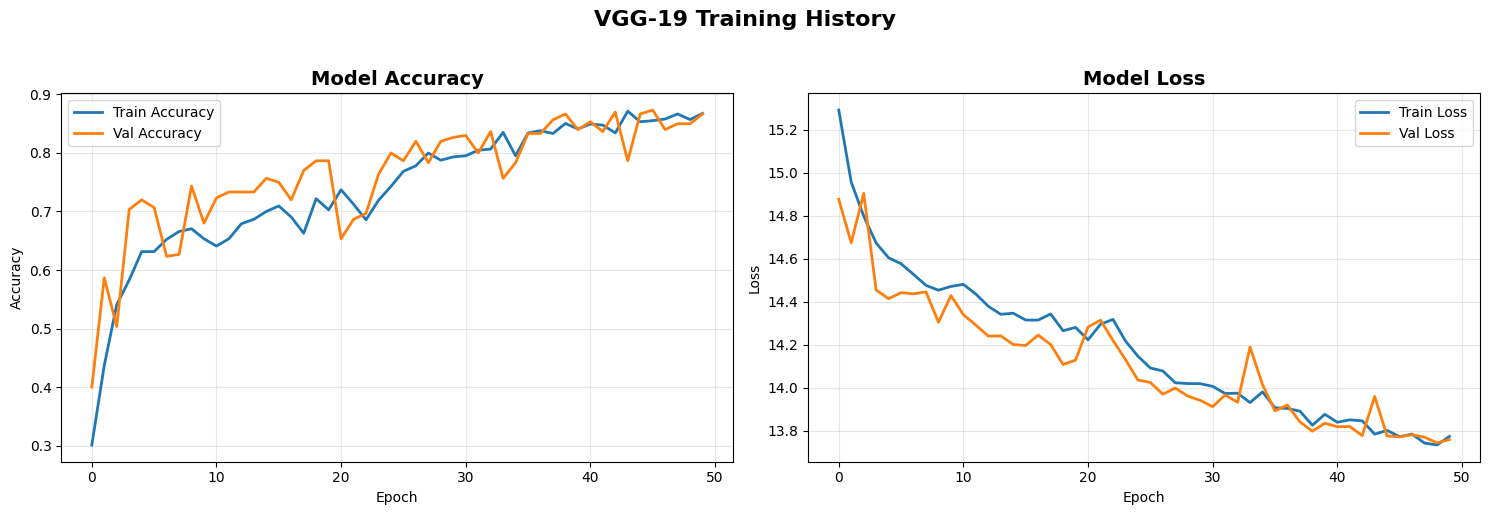

In [ ]:
def plot_training_history(history, save_path):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('VGG-19 Training History', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("\nPlotting training history...")
plot_training_history(history, os.path.join(model_save_path, 'training_history.png'))

In [ ]:

# Evaluate
test_results = vgg19_model.evaluate(test_generator, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")

# Get predictions
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = vgg19_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Calculate additional metrics from predictions
from sklearn.metrics import f1_score, precision_score, recall_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step - accuracy: 0.8461 - loss: 13.7451

Test Results:
  Loss: 13.7502
  Accuracy: 0.8533

Generating predictions...
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step
  Precision: 0.8659
  Recall: 0.8533
  F1-Score: 0.8505



Generating confusion matrix...


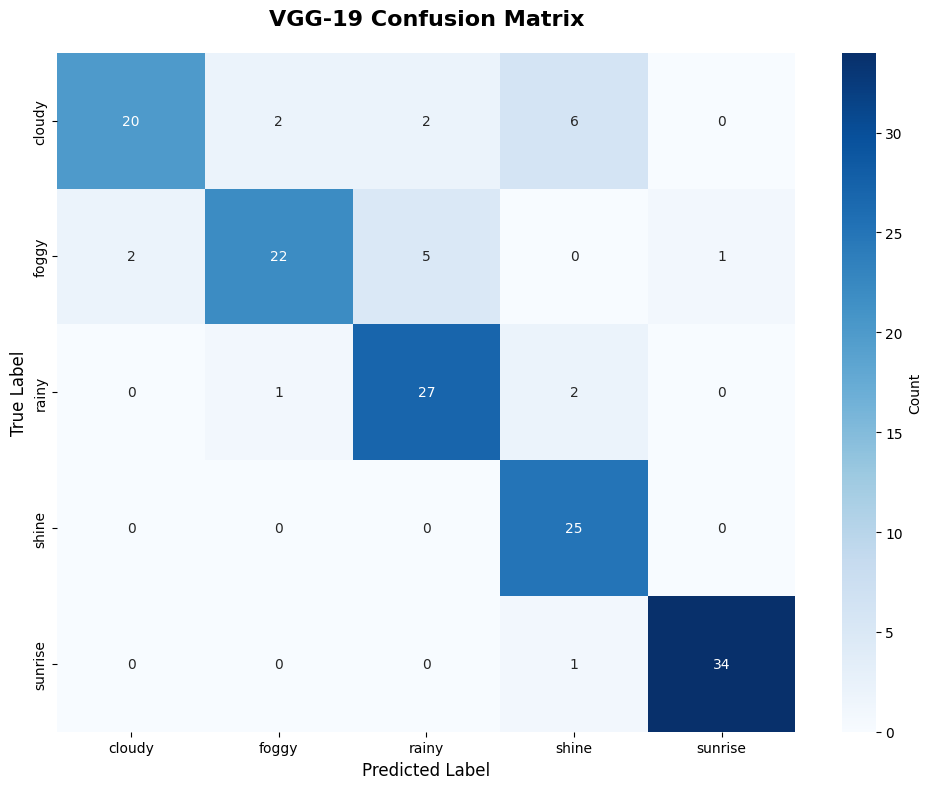

In [ ]:
print("\nGenerating confusion matrix...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('VGG-19 Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

ROC CURVE AND AUC

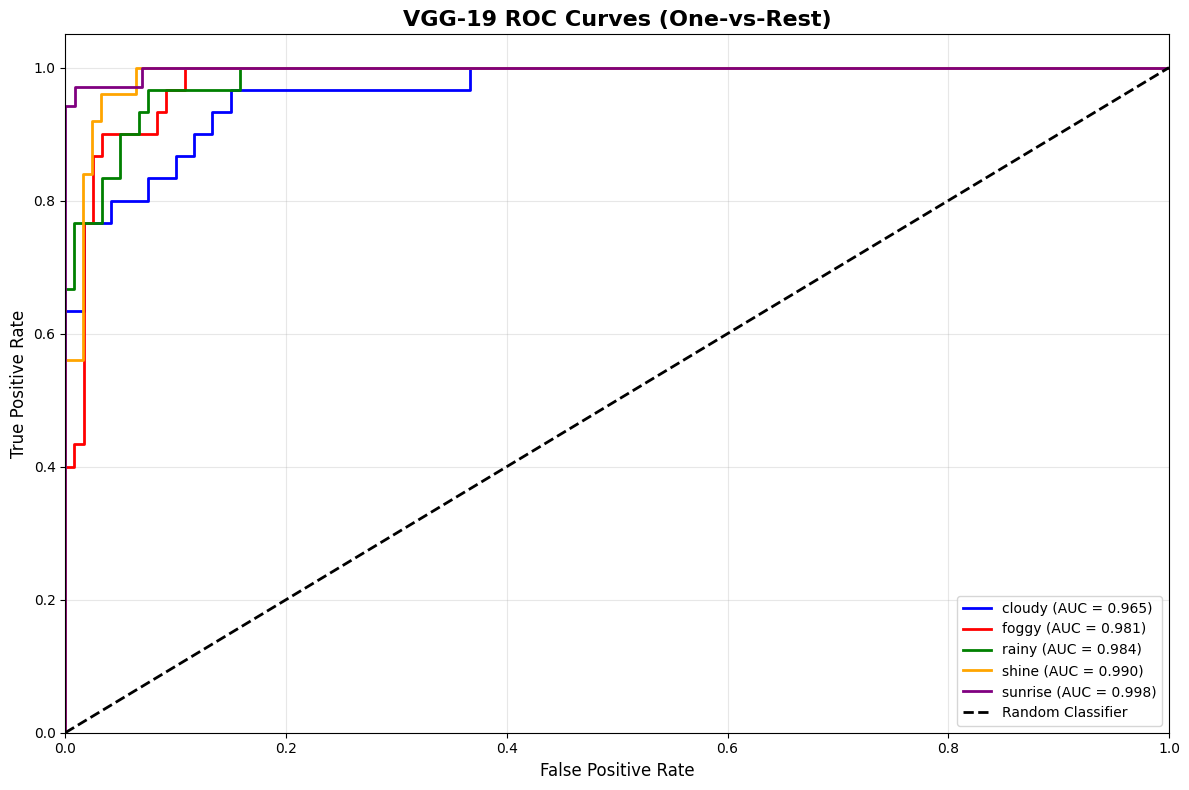


AUC Scores per Class:
  cloudy: 0.9650
  foggy: 0.9811
  rainy: 0.9836
  shine: 0.9898
  sunrise: 0.9978

Mean AUC: 0.9834


In [ ]:
# Binarize the labels for ROC curve
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('VGG-19 ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print AUC values
print("\nAUC Scores per Class:")
for i in range(NUM_CLASSES):
    print(f"  {CLASS_NAMES[i]}: {roc_auc[i]:.4f}")
print(f"\nMean AUC: {np.mean(list(roc_auc.values())):.4f}")

SAVE RESULTS

In [ ]:
results = {
    'model_name': 'VGG-19 From Scratch',
    'test_accuracy': float(test_accuracy),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1_score': float(f1),
    'test_loss': float(test_loss),
    'auc_scores': {CLASS_NAMES[i]: float(roc_auc[i]) for i in range(NUM_CLASSES)},
    'mean_auc': float(np.mean(list(roc_auc.values()))),
    'training_time_minutes': float(training_time/60),
    'total_params': int(total_params),
    'confusion_matrix': cm.tolist(),
    'class_names': CLASS_NAMES
}

np.save(os.path.join(model_save_path, 'results.npy'), results)